### ```Using Multiple Linear Regression with Least Squares Fit to Estimate NBA Player Point Futures```

### Libraries Utilized:

In [364]:
import numpy as np   # np is a standard shortcut.
import matplotlib.pyplot as plt # standard module for plots

###  1. Data Collection and Cleaning

#### Fetched game by game player data from [NBA API](https://github.com/swar/nba_api) using the common team roster and playergamelogs endpoints.

#### Removed all games with <10 minutes played for each player.

In [408]:
from nba_api.stats.endpoints import commonteamroster
from nba_api.stats.endpoints import playergamelogs
import pandas as pd
import os

team_dict = {'1610612743': 'nuggets',
             '1610612749': 'bucks', 
             '1610612738': 'celtics', 
             '1610612763': 'grizzlies', 
             '1610612758': 'kings', 
             '1610612755': '76ers', 
             '1610612739': 'cavaliers', 
             '1610612756': 'suns', 
             '1610612746': 'clippers', 
             '1610612752': 'knicks', 
             '1610612744': 'warriors', 
             '1610612751': 'nets', 
             '1610612747': 'lakers', 
             '1610612748': 'heat', 
             '1610612737': 'hawks', 
             '1610612750': 'timberwolves', 
             '1610612740': 'pelicans', 
             '1610612761': 'raptors', 
             '1610612741': 'bulls', 
             '1610612760': 'thunder', 
             '1610612742': 'mavericks', 
             '1610612754': 'pacers', 
             '1610612762': 'jazz', 
             '1610612764': 'wizards', 
             '1610612753': 'magic', 
             '1610612757': 'blazers', 
             '1610612745': 'rockets', 
             '1610612766': 'hornets', 
             '1610612765': 'pistons', 
             '1610612759': 'spurs'
            }

## seasonString: "2022-23"

directories = []

def getPlayerDataBySeason(seasonString):
    print(f"Gathering {seasonString} season data...")
    for teamId, team in team_dict.items():

        #get active players by team (FUNCTIONAL)
        roster = commonteamroster.CommonTeamRoster(league_id_nullable='00', season=seasonString, team_id=teamId)
        teamPlayerIds = roster.get_data_frames()[0]
        #create directory for each team
        directories.append(f"./{team}Data")
        try:  
            os.mkdir(f"{team}Data")  
            print(f"{team}Data directory created successfully ✔")
        except OSError as error:  
            print(error)  

        #iterate through player ids
        print(f"Collecting player data for {team}...")

        for index, row in teamPlayerIds.iterrows():
            print(f"Processing player data for {row['PLAYER']}...")
            playerStats = playergamelogs.PlayerGameLogs(
                player_id_nullable=row['PLAYER_ID'],
                season_nullable=seasonString,
                season_type_nullable='Regular Season'
            )
            playerStatsDF = playerStats.get_data_frames()[0]
            ##CLEANING
            cols = [11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 23, 24, 25, 26, 27, 31]
            playerStatsDF_correct_cols = playerStatsDF[playerStatsDF.columns[cols]]
            playerStatsDF_clean = playerStatsDF_correct_cols[playerStatsDF_correct_cols['MIN'] >= 10]
            #print("LEN", len(playerStatsDF_clean))
            if len(playerStatsDF_clean) != 0:
                playerStatsDF_clean.to_csv(f"./{team}Data/{row['PLAYER_SLUG']}.csv", index=False)
            print(f"{row['PLAYER_SLUG']}.csv created successfully ✔")

getPlayerDataBySeason('2023-24')

Gathering 2023-24 season data...
nuggetsData directory created successfully ✔
Processing player data for Christian Braun...
christian-braun.csv created successfully ✔
Processing player data for Michael Porter Jr....
michael-porter-jr.csv created successfully ✔
Processing player data for Julian Strawther...
julian-strawther.csv created successfully ✔
Processing player data for Hunter Tyson...
hunter-tyson.csv created successfully ✔
Processing player data for Kentavious Caldwell-Pope...
kentavious-caldwell-pope.csv created successfully ✔
Processing player data for DeAndre Jordan...
deandre-jordan.csv created successfully ✔
Processing player data for Reggie Jackson...
reggie-jackson.csv created successfully ✔
Processing player data for Peyton Watson...
peyton-watson.csv created successfully ✔
Processing player data for Justin Holiday...
justin-holiday.csv created successfully ✔
Processing player data for Braxton Key...
braxton-key.csv created successfully ✔
Processing player data for Niko

### 2. Prediction Method: Multiple Linear Regression

#### 'Given p predictors, we represent multiple linear regression as...' [1]

### $$y = \beta_{0} + \beta_{1}X_{1} + \beta_{1}X_{2} + ... + \beta_{p}X_{p} + \epsilon$$

#### Where epsilon represents error, since the correlation between X and y is not necessarily preserved between training and evaluation data sets. The estimation value is then:

### $$\hat{y} = \beta_{0} + \beta_{1}X_{1} + \beta_{1}X_{2} + ... + \beta_{p}X_{p}$$

#### Dependent Variable: Points Scored

#### Choosing Explanatory Variables by Assesing Correlations (Avoiding Multicollinearity)

[ 1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16. 17. 18.
 19.]


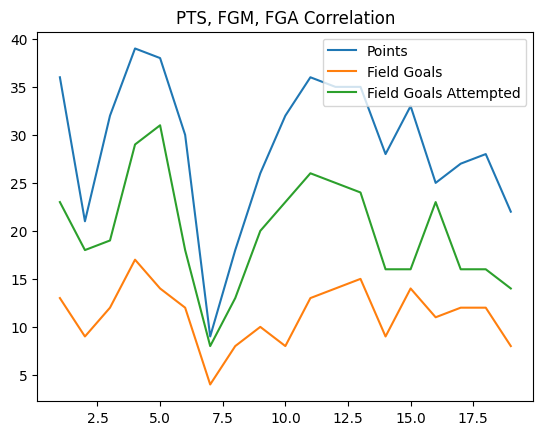

In [409]:
player_games = pd.read_csv("./nuggetsData/nikola-jokic.csv")

player_games_sub = player_games[:-1] # Remove the last game

PTS = player_games_sub['PTS'].values
                    
x  = np.linspace(1, len(PTS), len(PTS))
print(x)
plt.plot(x, player_games_sub['PTS'].values, label="Points")
plt.plot(x, player_games_sub['FGM'].values, label="Field Goals")
plt.plot(x, player_games_sub['FGA'].values, label="Field Goals Attempted")
plt.title('PTS, FGM, FGA Correlation')
plt.legend()

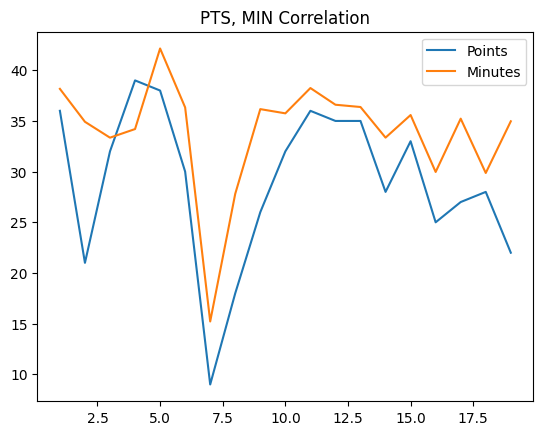

In [410]:
plt.plot(x, PTS, label="Points")
plt.plot(x, player_games_sub['MIN'].values, label="Minutes")
plt.title('PTS, MIN Correlation')
plt.legend()

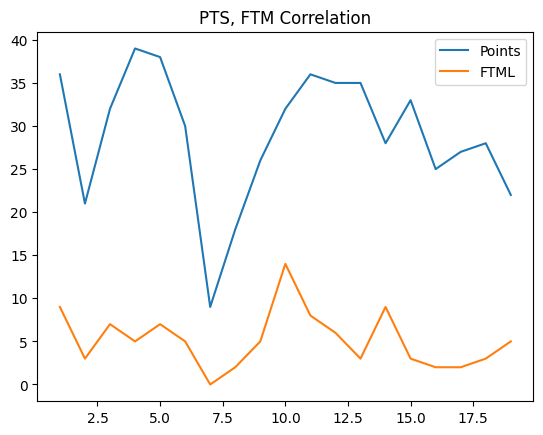

In [412]:
plt.plot(x, PTS, label="Points")
plt.plot(x, player_games_sub['FTM'].values, label="FTML")
plt.title('PTS, FTM Correlation')
plt.legend()

### Chosen Independent Variables:

- Field Goals Made (# Buckets)
- Field Goal Percentage
- 3 Points Made
- Free Throws Made
- Minutes Played
- Assists
- Rebounds
- Blocks 
- Turnovers


#### To estimate beta values (regression coefficients), a least squares fit is commonly used.

Text(0.5, 1.0, 'PTS Least Squares Fit')

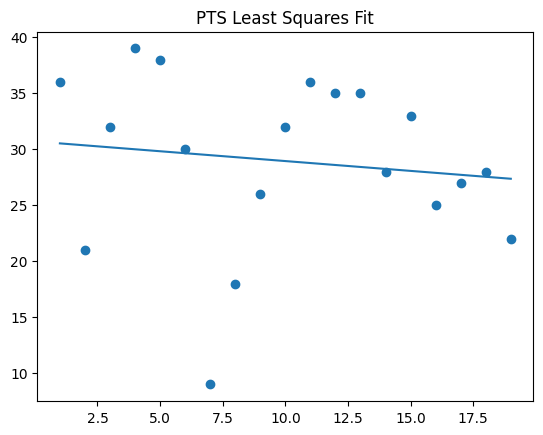

In [413]:
# For Previous Four Games:
# scores = scores[-4:]
# x = x[-4:]

#### np.lstq computes vector x that solves Ax = b, here A is the matrix of X values, x is the vector of 
#### regression coefficients, and b is the vector of representing values of the dependent variable.

X = np.stack((x, np.ones(len(PTS))),axis=1)
coeff = np.linalg.lstsq(X,PTS, rcond=None)[0]
plt.scatter(x,PTS)
plt.plot(x, coeff[0]*x + coeff[1])
plt.title('PTS Least Squares Fit')

#### With our game data, here we are using last season's final's MVP Nikola Jokic

In [442]:
FGM = player_games_sub['FGM']
FG_PCT = player_games_sub['FG_PCT']
FG3M = player_games_sub['FG3M']
FTM = player_games_sub['FTM']
MIN = player_games_sub['MIN']
AST = player_games_sub['AST']
TOV = player_games_sub['TOV']
REB = player_games_sub['REB']
BLK = player_games_sub['BLK'] 

X = np.stack((FGM,FG_PCT,FG3M,FTM,MIN,AST,TOV,REB,BLK),axis=1)
coeff = np.linalg.lstsq(X,PTS, rcond=None)[0]
print(coeff)

[ 2.00000000e+00 -8.02136135e-15  1.00000000e+00  1.00000000e+00
 -5.27355937e-16  2.22044605e-16  6.76542156e-17 -2.91433544e-16
 -1.56645530e-15]


#### 3. A First Prediction!

Using these coefficients, we can input new values ( current player averages ) to createa a prediction.

In [443]:
current_player_averages = []
for independent_variable in [FGM,FG_PCT,FG3M,FTM,MIN,AST,TOV,REB,BLK]:
    current_player_averages.append(np.mean(independent_variable))
print(current_player_averages)

[11.31578947368421, 0.5808947368421054, 1.1578947368421053, 5.157894736842105, 33.9080701754386, 9.736842105263158, 2.9473684210526314, 12.736842105263158, 0.7894736842105263]


In [444]:
y_hat = np.dot(coeff, current_player_averages) # the prediction
print('Nikola Jokic will score', y_hat, 'points next game.')

Nikola Jokic will score 28.947368421052584 points next game.


#### 4. Training & Testing Data

##### This model is currently, redundant, as it is training on the testing data. This is a 2:1 testing training split.

In [417]:
all_games = pd.read_csv("./nuggetsData/nikola-jokic.csv")

split = int(2/3 * len(all_games))

train = all_games.iloc[:split]
test = all_games.iloc[split:] # all games aside from the last

In [418]:
X_train = np.stack((train['FGM'],train['FG_PCT'],train['FG3M'],train['FG3M'],train['FTM'],train['MIN'],train['AST'], train['TOV'], train['REB'], train['BLK']),axis=1)
model = np.linalg.lstsq(X_train, train['PTS'], rcond=None)[0]
print(model)

[ 2.00000000e+00 -7.27196081e-15  5.00000000e-01  5.00000000e-01
  1.00000000e+00 -2.19269047e-15 -4.02455846e-16  1.70870262e-15
  5.55111512e-17 -4.69676381e-16]


In [419]:
test_player_averages = []
for independent_variable in [test['FGM'],test['FG_PCT'],test['FG3M'],test['FG3M'],test['FTM'],test['MIN'],test['AST'], test['TOV'], test['REB'], test['BLK']]:
    test_player_averages.append(np.mean(independent_variable))

print(test_player_averages)

[11.142857142857142, 0.6474285714285715, 1.4285714285714286, 1.4285714285714286, 3.7142857142857144, 33.60285714285714, 7.857142857142857, 3.7142857142857144, 12.714285714285714, 0.7142857142857143]


In [420]:
y_hat = np.dot(model, test_player_averages) # the prediction
print('Nikola Jokic will score', y_hat, 'points next game.') #different result

Nikola Jokic will score 27.428571428571356 points next game.


#### The error is then:

$$\epsilon = y - \hat{y}$$

In [421]:
y = test[-1:]['PTS'].values[0]
error = y - y_hat
print(f"ERROR {error} points")

ERROR 1.571428571428644 points


#### 5. Evaluation of the Model, an Iterative Approach (ALL NBA)

In [445]:
def error_analysis():
    expected = []
    actual = []
    for directory_path in directories:
        print(f"Analyzing {directory_path}")
        directory = os.listdir(directory_path)
        errorSum = 0
        for file in os.listdir('./nuggetsData'):
            # Construct the full path to the CSV file
            file_path = os.path.join('./nuggetsData', file)
            all_games = pd.read_csv(file_path)
            split = int(2/3 * len(all_games))
            train = all_games.iloc[:split]
            test = all_games.iloc[split:]
            X_train = np.stack((train['FGM'],train['FG_PCT'],train['FG3M'],train['FG3M'],train['FTM'],train['MIN'],train['AST'], train['TOV'], train['REB'], train['BLK']),axis=1)
            model = np.linalg.lstsq(X_train, train['PTS'], rcond=None)[0]
            test_player_averages = []
            for independent_variable in [test['FGM'],test['FG_PCT'],test['FG3M'],test['FG3M'],test['FTM'],test['MIN'],test['AST'], test['TOV'], test['REB'], test['BLK']]:
                test_player_averages.append(np.mean(independent_variable))
            y_hat = np.dot(model, test_player_averages)
            y = test[-1:]['PTS'].values[0]
            expected.append(y_hat)
            actual.append(y)
            error = y - y_hat
            print(f"{file_path} ERROR", error)
            errorSum += abs(error)
    return actual, expected, errorSum / len(directory)

actual, expected, avg_error = error_analysis()
print("AVERAGE ERROR:", avg_error, "points")

Analyzing ./nuggetsData
./nuggetsData/julian-strawther.csv ERROR -3.8268669352452243
./nuggetsData/kentavious-caldwell-pope.csv ERROR 10.428571428571436
./nuggetsData/collin-gillespie.csv ERROR 1.4278514481937123
./nuggetsData/jalen-pickett.csv ERROR -1.923450823789751
./nuggetsData/deandre-jordan.csv ERROR -3.6144231050575506
./nuggetsData/christian-braun.csv ERROR -3.4285714285711375
./nuggetsData/jamal-murray.csv ERROR 7.035320260736361
./nuggetsData/nikola-jokic.csv ERROR 1.571428571428644
./nuggetsData/zeke-nnaji.csv ERROR -1.098293993030227
./nuggetsData/aaron-gordon.csv ERROR 2.166666666666668
./nuggetsData/michael-porter-jr.csv ERROR -2.9999999999998366
./nuggetsData/peyton-watson.csv ERROR -3.166666666666658
./nuggetsData/reggie-jackson.csv ERROR -0.4285714285714235
./nuggetsData/justin-holiday.csv ERROR 0.2823421926434726
Analyzing ./bucksData
./nuggetsData/julian-strawther.csv ERROR -3.8268669352452243
./nuggetsData/kentavious-caldwell-pope.csv ERROR 10.428571428571436
./nug

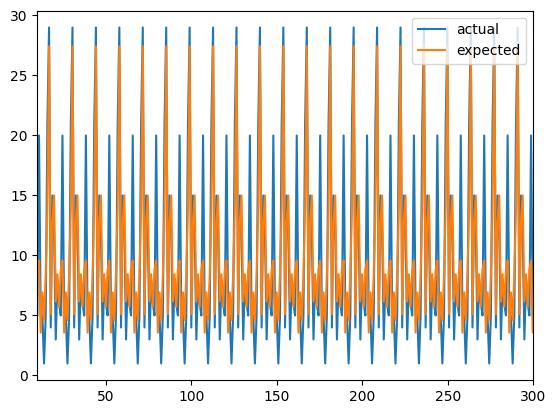

In [447]:
bound  = np.linspace(10, len(actual), len(actual))
plt.plot(bound, actual, label="actual")
plt.plot(bound, expected, label="expected")
plt.xlim(10, 300)
plt.legend()

#### 7. Conclusion

I see this model as being representative of the data. However, I still see a significant over fitting issue based on the relationship between expected and actual results. It was my original intention to accomplish the prediction using a Monte Carlo Simulation, however, I saw that this would be more applicable to final game spreads and ended up specifying the project to revolve around player scores.

#### 8. Thank you. Questions?

##### 8. References
- [1] Kayleigh Campbell, Benjamin Huang, Grabriel Katz, Skylar O'Connel, Diego Villalobos Gonzalez. 1978. LOGICS of Programs: AXIOMATICS and DESCRIPTIVE POWER. Player Performance Prediction Automation for DraftKings. Worcester Polytechnic Institute, Worcester, MA. [View Article](https://digital.wpi.edu/pdfviewer/s7526g506).
- [2] Cabarkapa D, Deane MA, Fry AC, Jones GT, Cabarkapa DV, Philipp NM, et al. (2022) Game statistics that discriminate winning and losing at the NBA level of basketball competition. PLoS ONE 17(8): e0273427. [View Article](https://doi.org/10.1371/journal.pone.0273427).